# Decision Tree

In [1]:
# # Black formatter https://black.readthedocs.io/en/stable/

# ! pip install nb-black > /dev/null

# %load_ext lab_black

In [2]:
TARGET = "Survived"

In [3]:
import os
from pathlib import Path
import time
import gc


import random
import pandas as pd
import numpy as np
import datatable as dt  # Fast table loading

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

import xgboost as xgb

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

plt.style.use("fivethirtyeight")  # ggplot fivethirtyeight bmh
pd.options.display.max_columns = 500

In [4]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")

    submission_df = pd.read_csv(data_dir / "gender_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [5]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission[:5]

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def show_scores(gt, yhat, is_log_target=False):
    if is_log_target:
        #         yhat = np.exp(yhat)
        yhat = np.expm1(yhat)
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    r2_square = r2_score(gt, yhat)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2_square:.4f}")

In [7]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [8]:
data_dir = "../input/titanic"

In [9]:
%%time
train, test, sample_submission = read_data(data_dir)

train data: Rows=891, Columns=12
test data : Rows=418, Columns=11
CPU times: user 11.8 ms, sys: 483 µs, total: 12.3 ms
Wall time: 26.4 ms


In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
drop_columns = ["PassengerId", "Name", "Ticket", "Cabin", "Fare"]
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

In [12]:
## Separate Categorical and Numerical Features
cat_features = list(train.select_dtypes(include=["category", "object"]).columns)
num_features = list(test.select_dtypes(include=["number"]).columns)

FEATURES = cat_features + num_features

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

train[cat_features] = imputer.fit_transform(train[cat_features])
test[cat_features] = imputer.transform(test[cat_features])

imputer = SimpleImputer(strategy="mean")
# imputer = SimpleImputer(strategy="median")  # median is more robust to outliers

train[num_features] = imputer.fit_transform(train[num_features])
test[num_features] = imputer.transform(test[num_features])

In [14]:
train, test = label_encoder(train, test, cat_features)

In [15]:
train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64

In [16]:
FEATURES = ["Pclass","Age","Sex","Embarked"]

In [17]:
X = train[FEATURES].copy()
y = train[TARGET]
X_test = test[FEATURES].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
X_train.head()

,Pclass,Age,Sex,Embarked
331,1.0,45.5,1,2
733,2.0,23.0,1,2
382,3.0,32.0,1,2
704,3.0,26.0,1,2
813,3.0,6.0,0,2


## DecisionTreeClassifier

- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [19]:
from sklearn import tree

model = tree.DecisionTreeClassifier(criterion='gini', # gini, entropy
                                    splitter='best',
                                    max_depth=4,
                                    random_state=42)
# model = tree.DecisionTreeClassifier()
clf = model.fit(X_train, y_train)

In [20]:
from sklearn.tree import export_text

tree_rules = export_text(clf, feature_names=FEATURES)
# tree_rules = export_text(clf)


print(tree_rules)

|--- Sex <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- Pclass <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- Pclass >  1.50
|   |   |   |   |--- class: 1
|   |   |--- Age >  2.50
|   |   |   |--- Age <= 27.50
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  27.50
|   |   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Embarked <= 1.50
|   |   |   |--- Age <= 13.75
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  13.75
|   |   |   |   |--- class: 1
|   |   |--- Embarked >  1.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- class: 0
|--- Sex >  0.50
|   |--- Age <= 6.50
|   |   |--- Pclass <= 2.50
|   |   |   |--- class: 1
|   |   |--- Pclass >  2.50
|   |   |   |--- Age <= 2.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  2.50
|   |   |   |   |--- class: 1
|   |--- Age >  6.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- Age <= 17.50
|   |   |   |   |--- cla

In [21]:
# import graphviz

# dot_data = tree.export_graphviz(
#     clf,
#     out_file=None,
#     feature_names=X.columns,
#     class_names=train["Survived"],
#     filled=True,
#     rounded=True,
#     special_characters=True,
# )
# # graph = graphviz.Source(dot_data)
# # graph.render("auto")

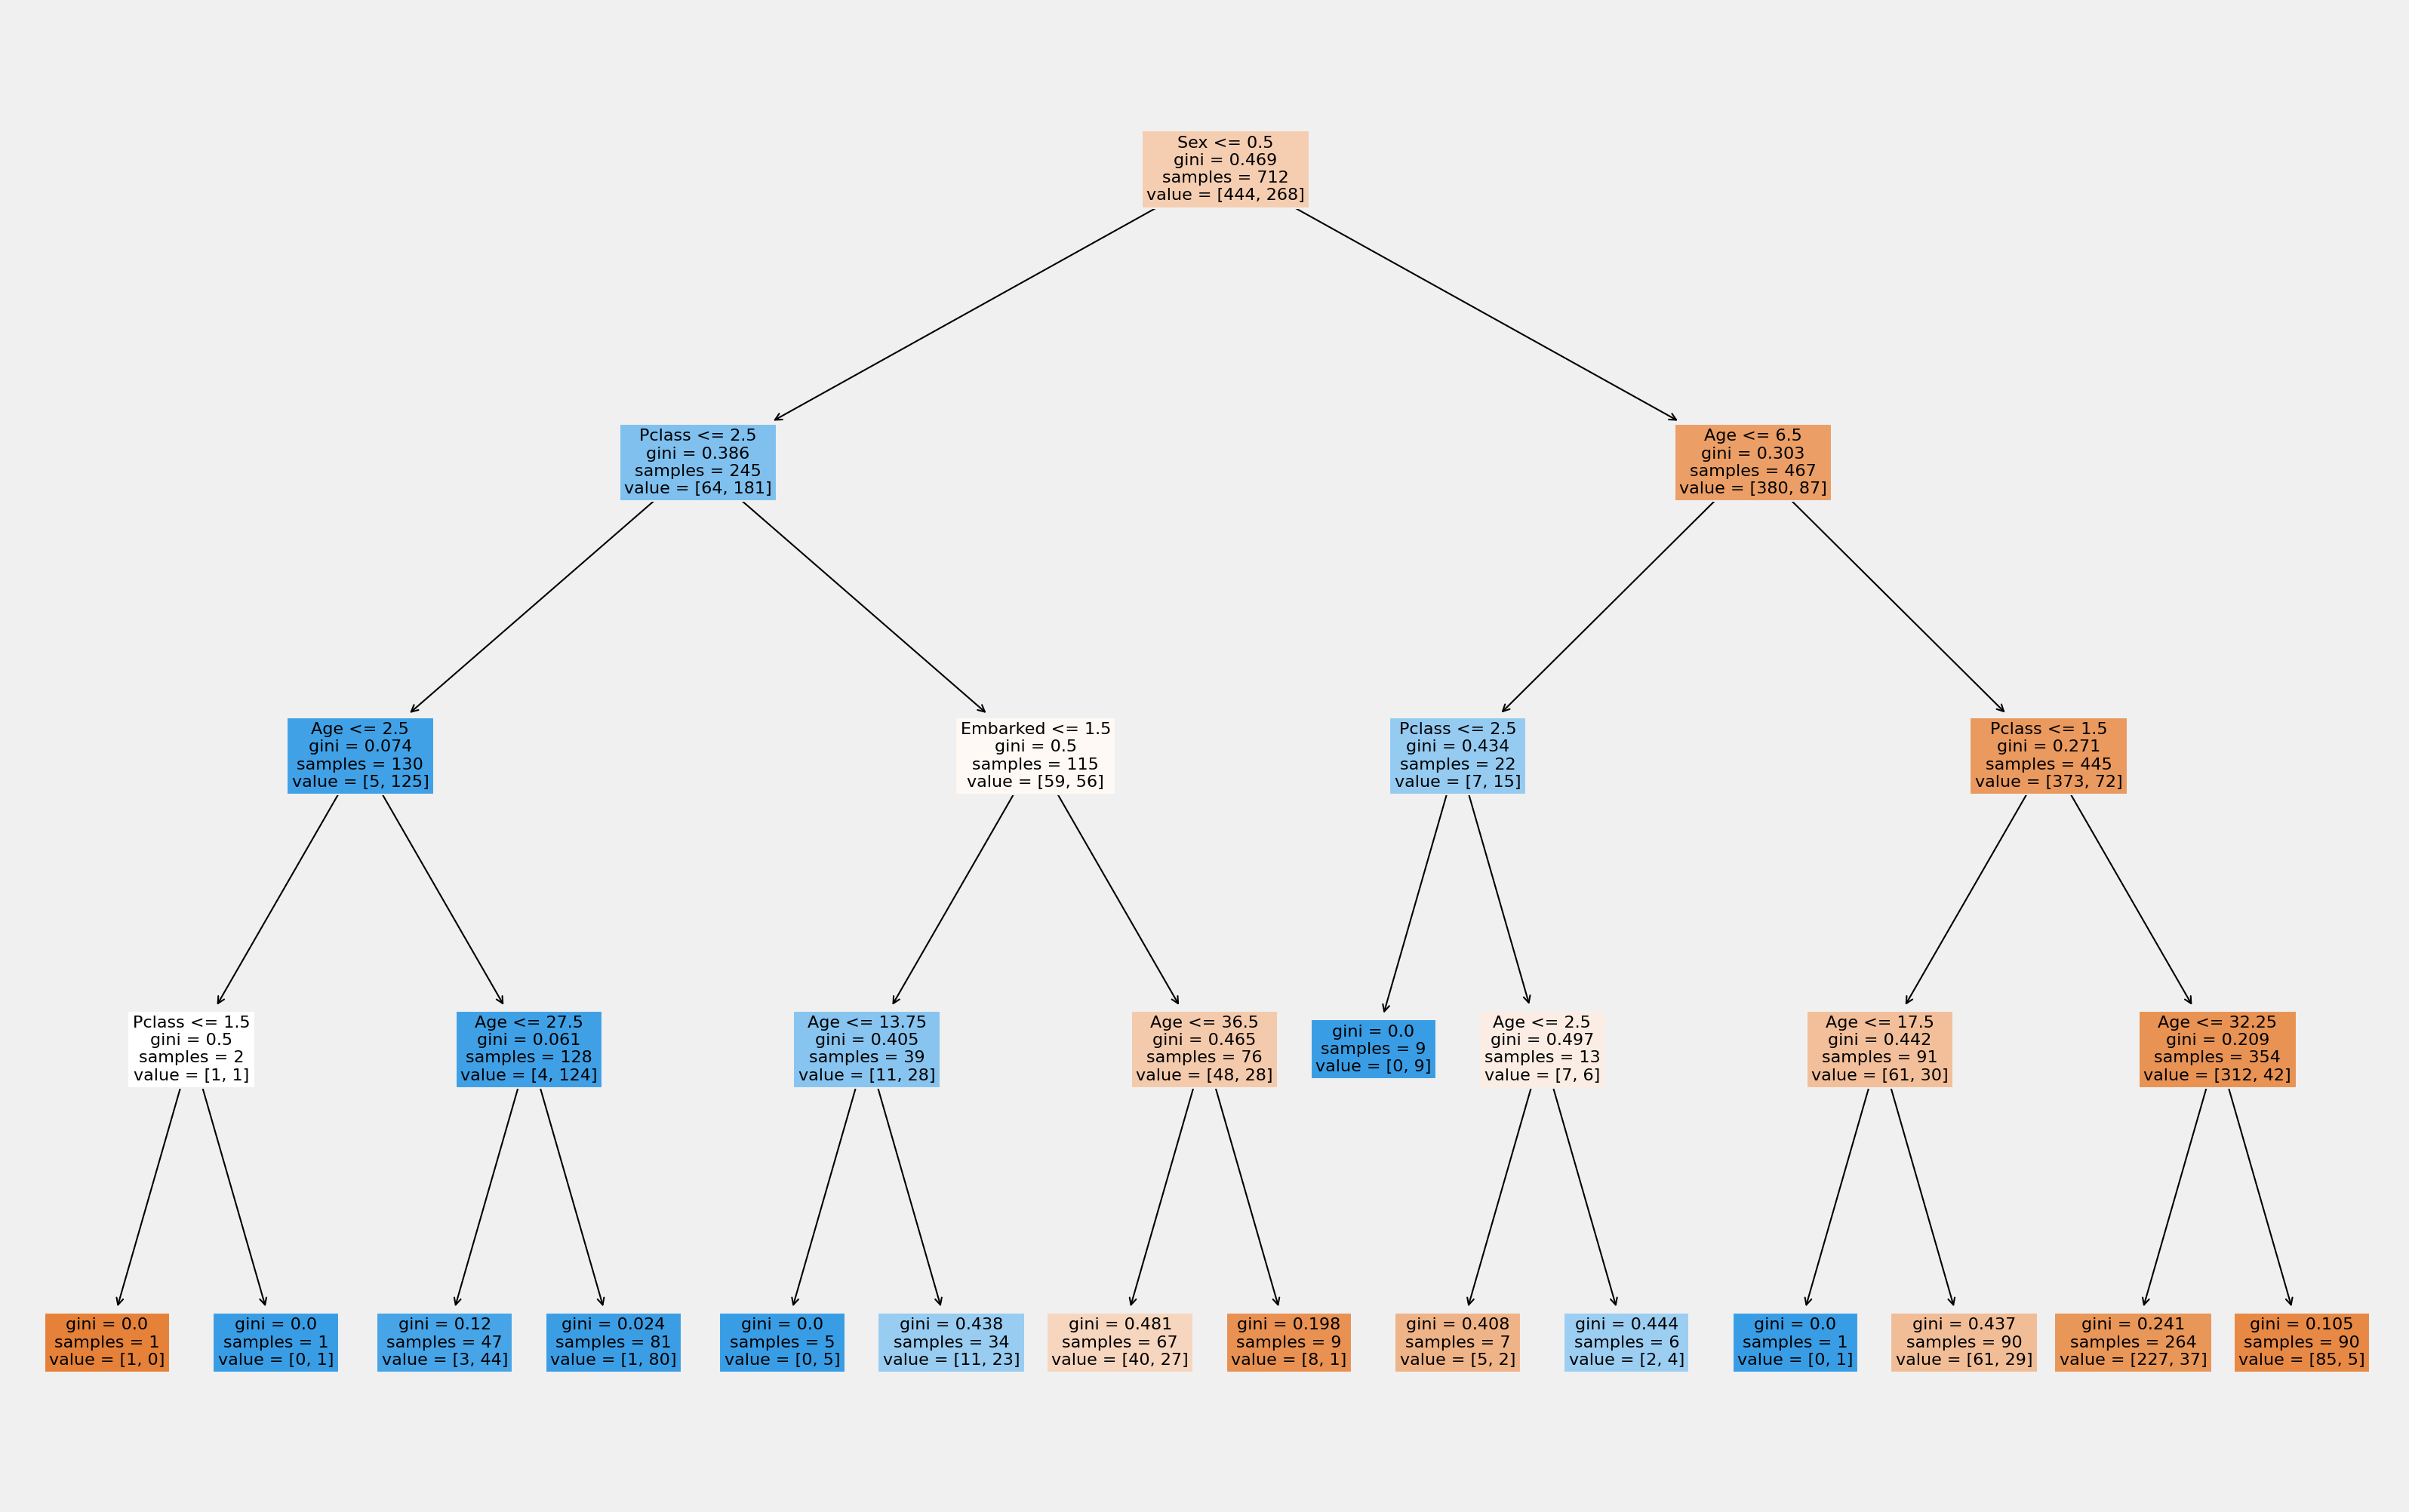

In [22]:
from sklearn import tree

# tree.plot_tree(clf)
plt.figure(figsize=(12, 8), dpi=300)
tree.plot_tree(clf, filled=True, feature_names=X.columns)
plt.show()

In [23]:
# import graphviz

# dot_data = tree.export_graphviz(
#     clf,
#     out_file=None,
#     feature_names=FEATURES,
#     class_names=train[TARGET],
#     filled=True,
#     rounded=True,
# #     special_characters=True
# )
# graph = graphviz.Source(dot_data)
# graph.render("auto")

In [24]:
valid_preds = model.predict(X_valid)
show_scores(y_valid, valid_preds)

MAE: 0.2011
MSE: 0.2011
RMSE: 0.4485
R^2: 0.1707


In [25]:
valid_preds[:20]

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [26]:
test_preds = model.predict(X_test)

create_submission("", TARGET, test_preds)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [27]:
test_preds

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,